<a href="https://colab.research.google.com/github/SomtochukwuAnyigor/E-Commerce-Customer-Segmentation-ML/blob/main/E_Commerce_Customer_Segmentation_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

# Direct link to the Excel file on UCI's server
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'

print("Downloading and loading data... this might take a minute.")
df = pd.read_excel(url)

# --- PRE-PROCESSING (The 'Pro' Steps) ---
# 1. Drop rows with no CustomerID
df = df.dropna(subset=['CustomerID'])

# 2. Remove cancellations (Quantity < 0)
df = df[df['Quantity'] > 0]

# 3. Create TotalSum column
df['TotalSum'] = df['Quantity'] * df['UnitPrice']

# 4. Ensure InvoiceDate is the right format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("Data loaded and cleaned!")
print(df.head())

Data loaded and cleaned!
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalSum  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom     15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom     20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom     22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom     20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom     20.34  


In [3]:
import datetime as dt

# 1. Define a 'Snapshot Date' (one day after the last transaction)
# This serves as "today" for our analysis
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# 2. Group by CustomerID to calculate R, F, and M
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'
})

# 3. Rename columns for clarity
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'Monetary'
}, inplace=True)

# 4. Filter out any customers with 0 monetary value to avoid log errors later
rfm = rfm[rfm['Monetary'] > 0]

print("RFM Table Created!")
print(rfm.head())

RFM Table Created!
            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2        182   4310.00
12348.0          75         31   1797.24
12349.0          19         73   1757.55
12350.0         310         17    334.40


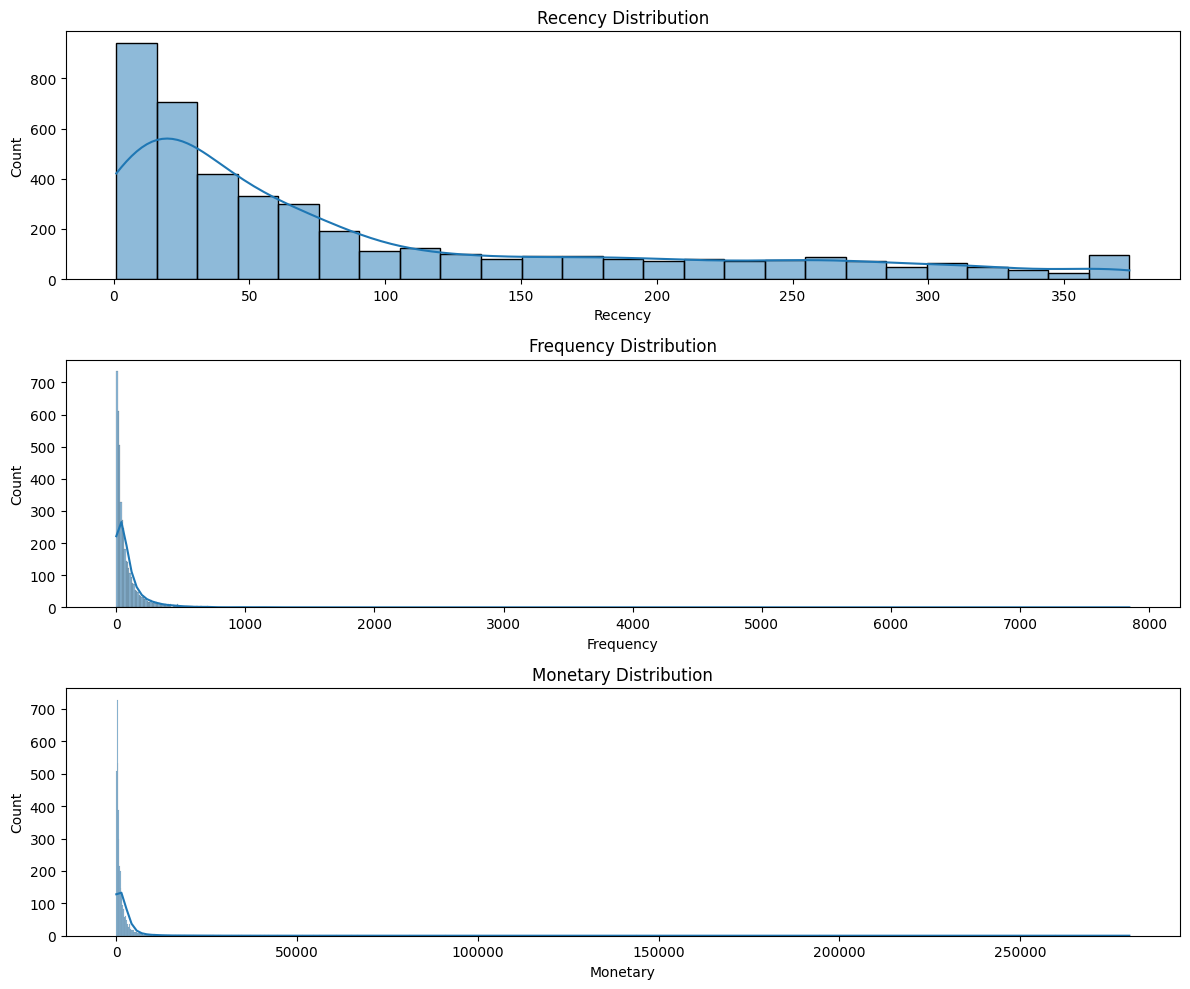

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of R, F, and M
plt.figure(figsize=(12,10))

# Plot Recency
plt.subplot(3, 1, 1); sns.histplot(rfm['Recency'], kde=True)
plt.title('Recency Distribution')

# Plot Frequency
plt.subplot(3, 1, 2); sns.histplot(rfm['Frequency'], kde=True)
plt.title('Frequency Distribution')

# Plot Monetary
plt.subplot(3, 1, 3); sns.histplot(rfm['Monetary'], kde=True)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

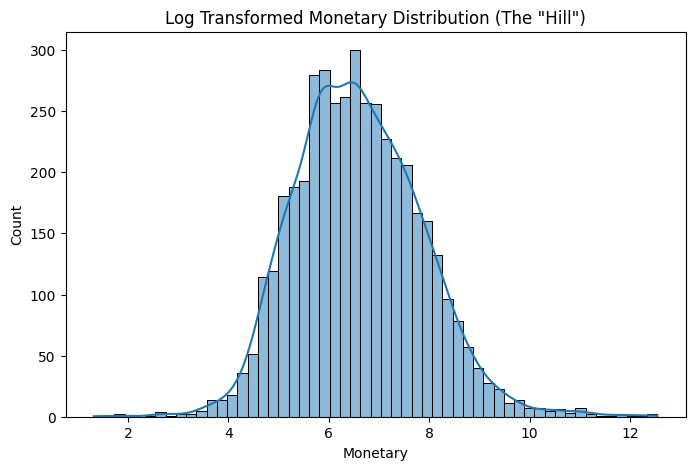

In [5]:
import numpy as np

# Apply Log Transformation to handle skewness
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis=1)

# Plot the new distribution for Monetary
plt.figure(figsize=(8,5))
sns.histplot(rfm_log['Monetary'], kde=True)
plt.title('Log Transformed Monetary Distribution (The "Hill")')
plt.show()

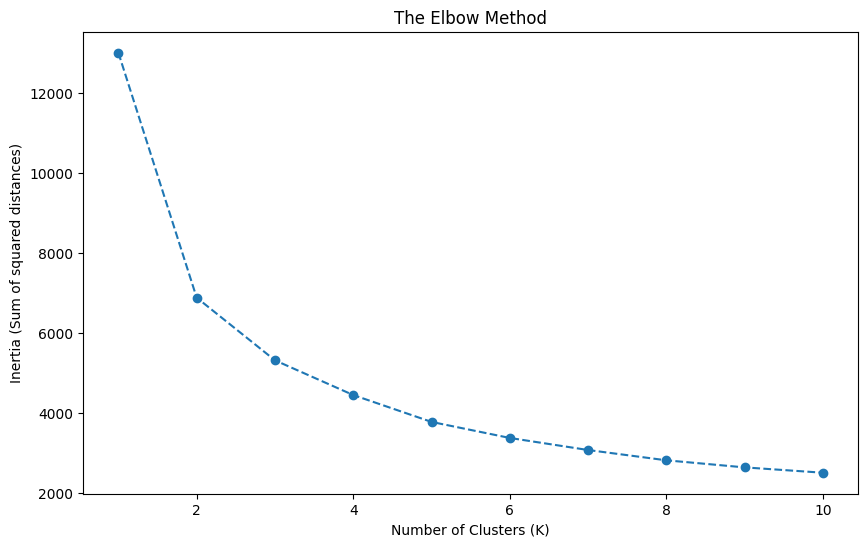

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# 2. Use the Elbow Method to find the best number of clusters (K)
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10,6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.show()

--- The Three Customer Segments ---
         Recency  Frequency  Monetary
Cluster                              
1           13.1      261.8    6523.9
2           69.4       66.1    1169.8
0          171.3       14.9     294.2


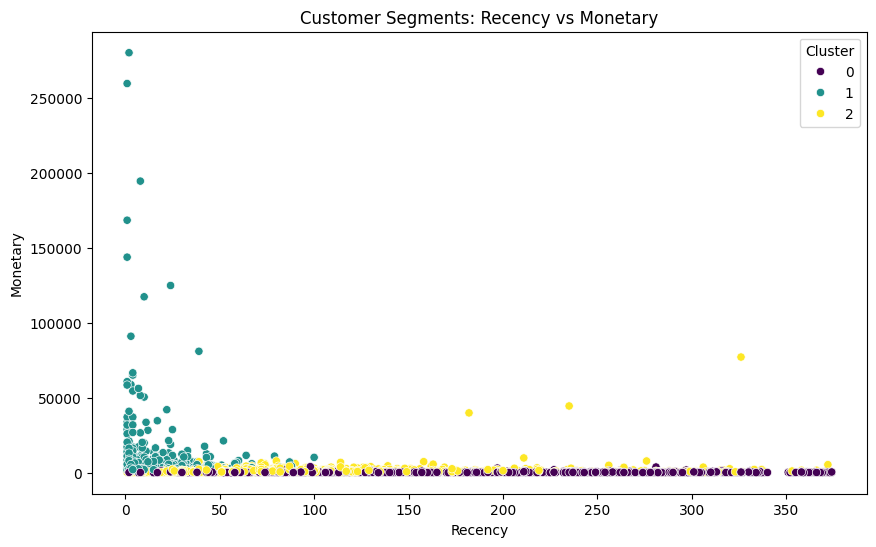

In [7]:
# 1. Apply K-Means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# 2. Analyze the characteristics of each cluster
cluster_analysis = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(1)

# Sort by Monetary to make it easier to read (highest spenders at the top)
cluster_analysis = cluster_analysis.sort_values(by='Monetary', ascending=False)

print("--- The Three Customer Segments ---")
print(cluster_analysis)

# 3. Visualize the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Customer Segments: Recency vs Monetary')
plt.show()

--- The 4 Customer Segments ---
         Recency  Frequency  Monetary
Cluster                              
1           12.9      285.4    7173.0
2           99.7       78.9    1482.0
0           19.2       41.4     634.8
3          181.6       14.5     286.4


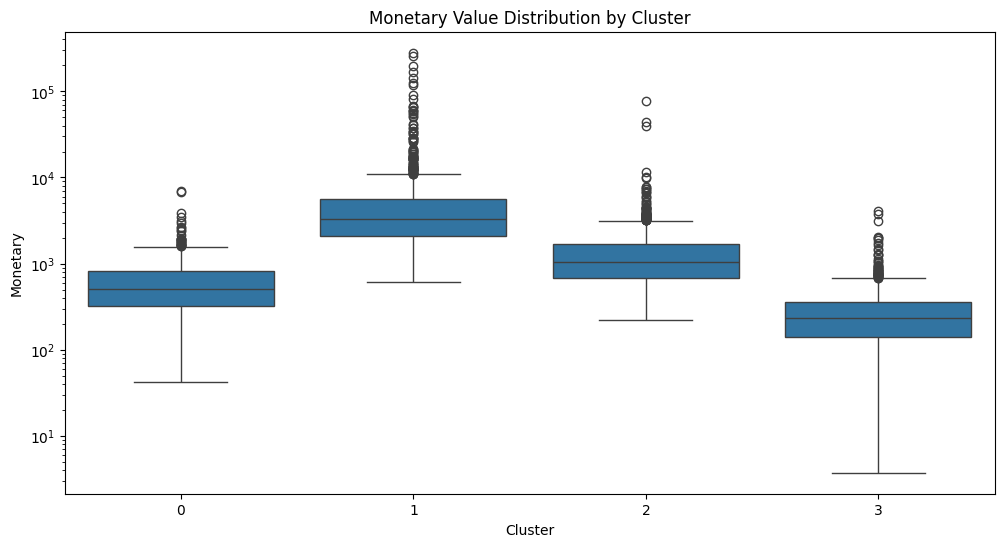

In [8]:
# 1. Apply K-Means with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# 2. Create the Summary Table
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(1)

# 3. Logic to help you identify which is which:
# Sort by Monetary to identify the tiers
cluster_summary = cluster_summary.sort_values(by='Monetary', ascending=False)

print("--- The 4 Customer Segments ---")
print(cluster_summary)

# 4. Visualization
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Monetary', data=rfm)
plt.yscale('log') # Using log scale to see the boxes clearly
plt.title('Monetary Value Distribution by Cluster')
plt.show()

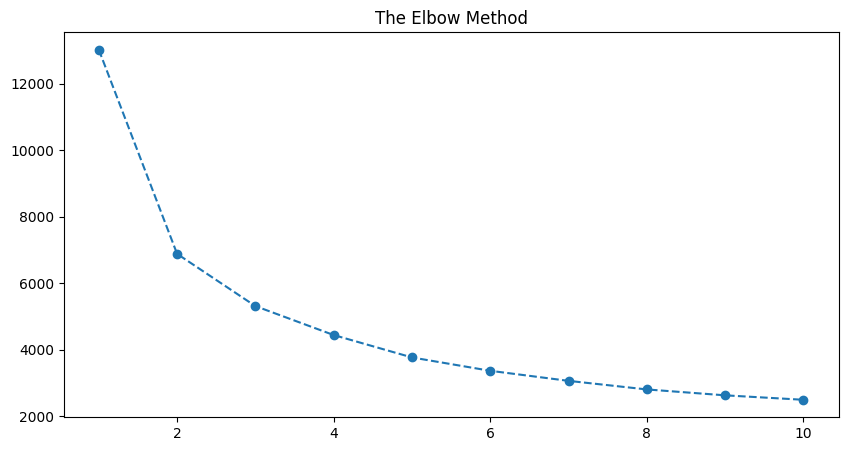

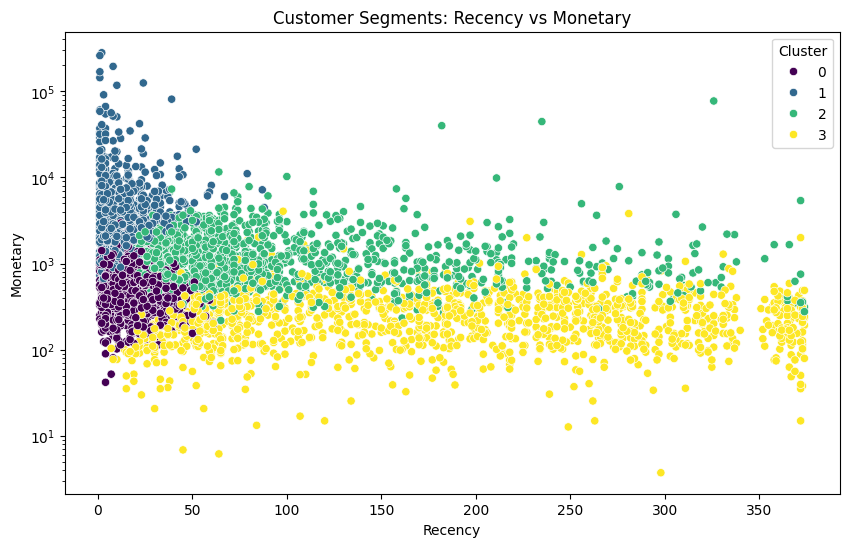

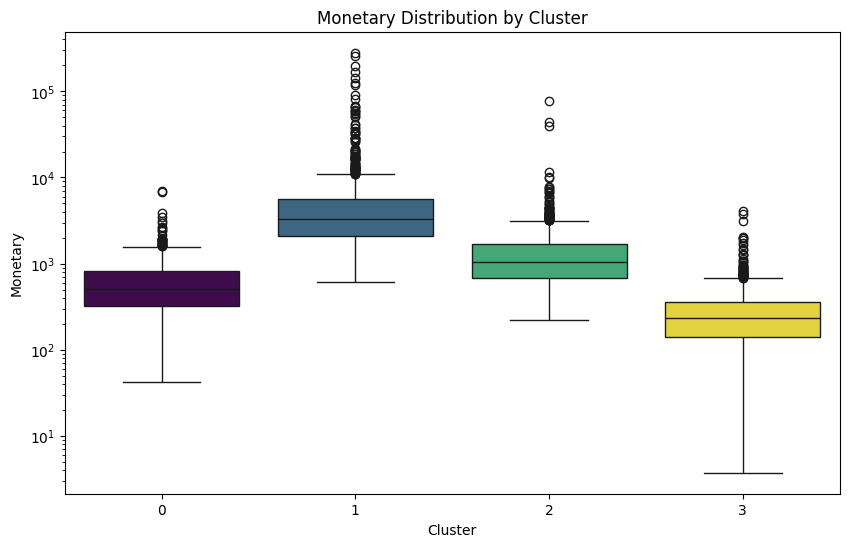

All 3 visualizations are saved to the sidebar! Download them now.


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 3 subplots or just save them one by one
# 1. The Elbow Curve (to prove your K choice)
plt.figure(figsize=(10,5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('The Elbow Method')
plt.savefig('elbow_curve.png')
plt.show()

# 2. The Scatter Plot (to show the clouds of customers)
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.yscale('log') # Log scale helps see the spread better
plt.title('Customer Segments: Recency vs Monetary')
plt.savefig('customer_clusters.png')
plt.show()

# 3. The Box Plot (the "statistical proof" we just discussed)
plt.figure(figsize=(10,6))
sns.boxplot(x='Cluster', y='Monetary', data=rfm, hue='Cluster', palette='viridis', legend=False)
plt.yscale('log')
plt.title('Monetary Distribution by Cluster')
plt.savefig('monetary_boxplot.png')
plt.show()

print("All 3 visualizations are saved to the sidebar! Download them now.")